In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from collections import defaultdict

In [2]:
output_base_folder = Path("/home/ivan/Documents/git/storage-benchmarking/src/benchmark_output")

In [3]:
s3_folder_filter="2810/*benchmark_e2e_s3*"

In [4]:
def extract_timelines(output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,
):
    files = list(output_base_folder.rglob(f"{folder_filter}/timeline-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0:
            continue
        results = pd.DataFrame.from_records(data=results)
        results = pd.merge(results[results["end_time"].isnull()], 
                           results[results["start_time"].isnull()], 
                           left_on='id', 
                           right_on='id').drop(['end_time_x', 
                                                      'start_time_y'], axis=1)
        results["source_file"] = working_file_path
        results["run"] = working_file_path.parent.name
        # filter out old data format missing dataset etc.
        data.append(results)
    df = pd.concat(data)
    df.groupby
    return df


In [5]:
df_dataloader = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 124.60it/s]


In [6]:
df_dataloader.sort_values(["start_time_x"], ascending=False)

,item_x,id,start_time_x,item_y,end_time_y,source_file,run
44,run_training_batch,588476520485273950,1.636064e+09,run_training_batch,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231332_benchmark_e2e_s3_4_2_16_1_vani...
43,training_batch_to_device,588476520485273951,1.636064e+09,training_batch_to_device,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231332_benchmark_e2e_s3_4_2_16_1_vani...
42,next_data,14,1.636064e+09,next_data,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231332_benchmark_e2e_s3_4_2_16_1_vani...
41,run_training_batch,8564810657280490340,1.636064e+09,run_training_batch,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231332_benchmark_e2e_s3_4_2_16_1_vani...
40,training_batch_to_device,1647281629639408488,1.636064e+09,training_batch_to_device,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231332_benchmark_e2e_s3_4_2_16_1_vani...
...,...,...,...,...,...,...,...
1,training_batch_to_device,1265592847885689831,1.636064e+09,training_batch_to_device,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231146_benchmark_e2e_s3_4_2_16_1_vani...
0,batch,-5837640237450333633,1.636064e+09,batch,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231146_benchmark_e2e_s3_4_2_16_1_vani...
1,batch,-5133125421876715600,1.636064e+09,batch,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231146_benchmark_e2e_s3_4_2_16_1_vani...
0,batch,7327027465595056883,1.636064e+09,batch,1.636064e+09,/home/ivan/Documents/git/storage-benchmarking/...,20211104f231146_benchmark_e2e_s3_4_2_16_1_vani...


In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [8]:
colors={}
unique_functions = np.unique(df_dataloader["item_x"])
for i, color in zip(unique_functions, ["red", "gold", "blue", "magenta", "aqua"]):
    colors[str(i)] = color
lanes={}
for i, lane in zip(unique_functions, range(len(unique_functions))):
    lanes[str(i)] = lane

In [9]:
lanes

{'batch': 0,
 'next_data': 1,
 'run_training_batch': 2,
 'training_batch_to_device': 3}

In [10]:
unique_runs = np.unique(df_dataloader["run"])
unique_runs

array(['20211104f231146_benchmark_e2e_s3_4_2_16_1_vanilla_sync',
       '20211104f231332_benchmark_e2e_s3_4_2_16_1_vanilla_sync'],
      dtype=object)

In [11]:
def show_timelines(df, run, flat=False):
    fig, ax = plt.subplots(figsize=(15, 5))
    # fig, ax = plt.subplots()
    data = defaultdict(list)
    start = min(df["start_time_x"]) 
    i = 0
    for index, row in df.iterrows():
        duration = row["end_time_y"] - row["start_time_x"] 
        x1 = row["start_time_x"] - start 
        if duration < 0.08:
            duration = 0.1
        x2 = x1 + duration
        if not flat:
            lane = i
            i += 2
        else:
            lane = lanes[row["item_x"]]
        ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=4)
    ax.set_xlabel("Experiment duration", loc="center")
    ax.set_ylabel("Item", loc="top")
    ax.set_title(f"Runtime for each function, impl: {run.split('_')[8]},"
                 f"cache: {run.split('_')[7]}, "
                 f"batch size: {run.split('_')[4]}",
                 loc='center')
    ax.legend()
    ax.grid(linestyle='--', which="both")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Put a legend below current axis
    ax.legend(by_label.values(), by_label.keys(), 
              loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.show()


In [12]:
# for run in unique_runs:
#     df = df_dataloader[df_dataloader["run"]==run]
#     show_timelines(df, run, True)

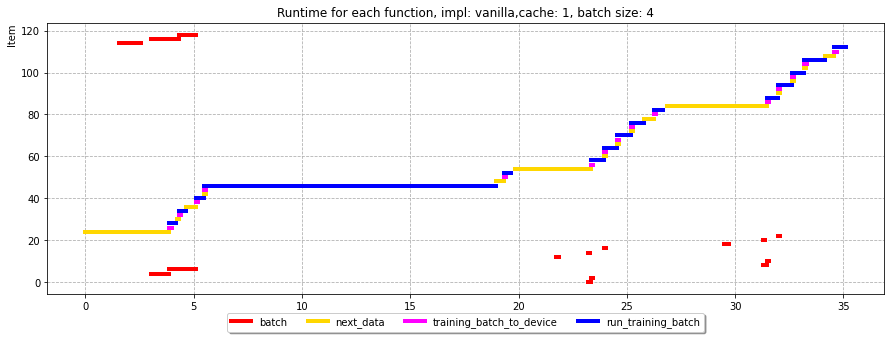

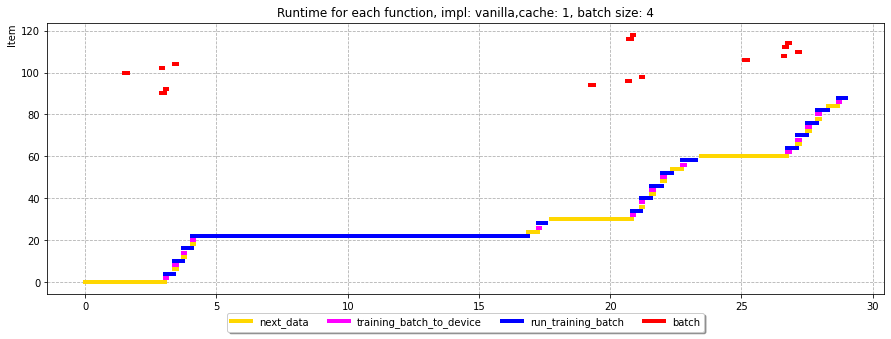

In [13]:
for run in unique_runs:
    df = df_dataloader[df_dataloader["run"]==run]
    show_timelines(df, run, False)
# Second run is without caching...

In [14]:
def extract_gpuutil(output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,
):
    files = list(output_base_folder.rglob(f"{folder_filter}/gpuutil-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0:
            continue
        header = []
        header.append("timestamp")
        for i in results[0]["gpu_data"]:
            header.append(f"gpu_{i}")
        header.append("run")
        lines = []
        for result in results:
            line = []
            line.append(result["timestamp"])
            for item in result["gpu_data"]:
                line.append(result["gpu_data"][item]["gpu_util"])
            line.append(working_file_path.parent.name)
            lines.append(line)
        results = pd.DataFrame.from_records(lines)
        data.append(results)
    df = pd.concat(data)
    df.columns = header
    df.groupby
    df.sort_values(["timestamp"], ascending=True)
    return df

In [15]:
# df_gpuutil = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)

In [16]:
df_gpuutil

NameError: name 'df_gpuutil' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
for run in df_gpuutil:
    for i in list(df_gpuutil[k]):
        if not np.all(np.array(df_gpuutil[k][i]) == 0):
            ax.plot(df_gpuutil[k][i], linewidth=2)
plt.show()

In [ ]:
df_gpuutil